# Mammograms Classification with YOLO

In [103]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from utils import show_batch, show_pred_example
from model import yolov1, tiny_yolov1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example Images

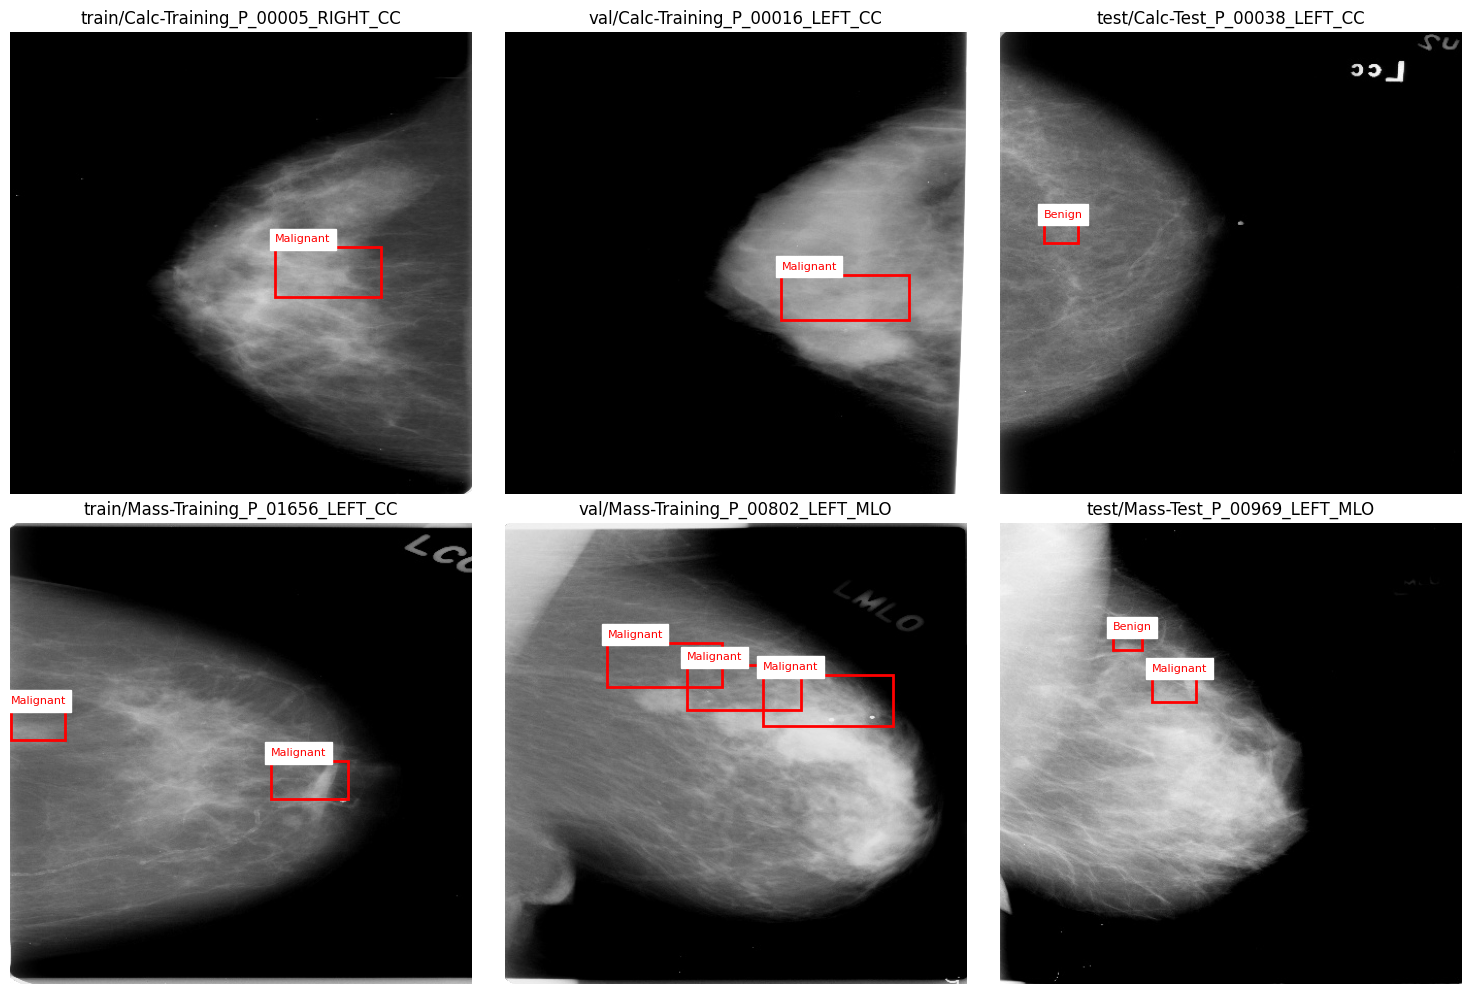

In [104]:
img_dir="data/images"
label_dir="data/labels/"
img_id = ["train/Calc-Training_P_00005_RIGHT_CC", "val/Calc-Training_P_00016_LEFT_CC", "test/Calc-Test_P_00038_LEFT_CC",
          "train/Mass-Training_P_01656_LEFT_CC", "val/Mass-Training_P_00802_LEFT_MLO", "test/Mass-Test_P_00969_LEFT_MLO" ]
show_batch(img_id, img_dir, label_dir)

## Load Model


In [105]:
model_tiny = tiny_yolov1()
model = yolov1()

In [106]:
model_tiny.summary()

Model: "tiny_yolov1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 448, 448, 1)]     0         
                                                                 
 convolutional_0 (Conv2D)    (None, 448, 448, 16)      160       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 224, 224, 16)     0         
 g2D)                                                            
                                                                 
 convolutional_1 (Conv2D)    (None, 224, 224, 32)      4640      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 convolutional_2 (Conv2D)    (None, 112, 112, 64)      

In [107]:
model.summary()

Model: "yolov1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 448, 448, 1)]     0         
                                                                 
 convolutional_0 (Conv2D)    (None, 224, 224, 64)      3200      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 convolutional_1 (Conv2D)    (None, 112, 112, 192)     602304    
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 56, 56, 192)      0         
 g2D)                                                            
                                                                 
 convolutional_2 (Conv2D)    (None, 56, 56, 128)       24704

In [108]:
model_tiny.load_weights('checkpoints/tiny_yolo_best.h5')
model.load_weights('checkpoints/yolo_best.h5')

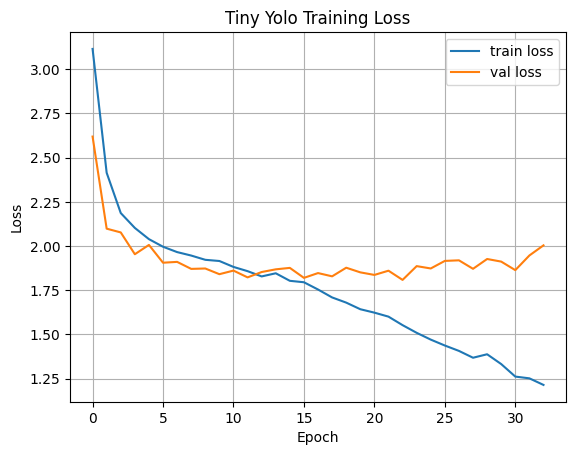

In [109]:
history_tiny_df = pd.read_csv('history/training_tiny.csv')

plt.plot(history_tiny_df['loss'], label='train loss')
plt.plot(history_tiny_df['val_loss'], label='val loss')
plt.legend()
plt.title("Tiny Yolo Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.savefig("graphs/tiny_yolo_training.pdf", bbox_inches='tight')

plt.show()

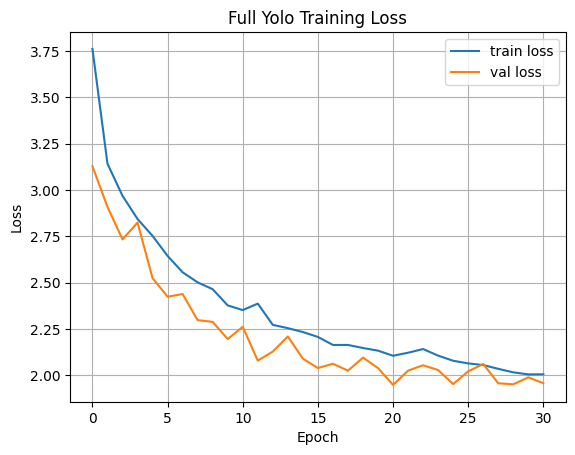

In [110]:
history_df = pd.read_csv('history/training.csv')

plt.plot(history_df['loss'], label='train loss')
plt.plot(history_df['val_loss'], label='val loss')
plt.legend()
plt.title("Full Yolo Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.savefig("graphs/yolo_training.pdf", bbox_inches='tight')

plt.show()

## Performance

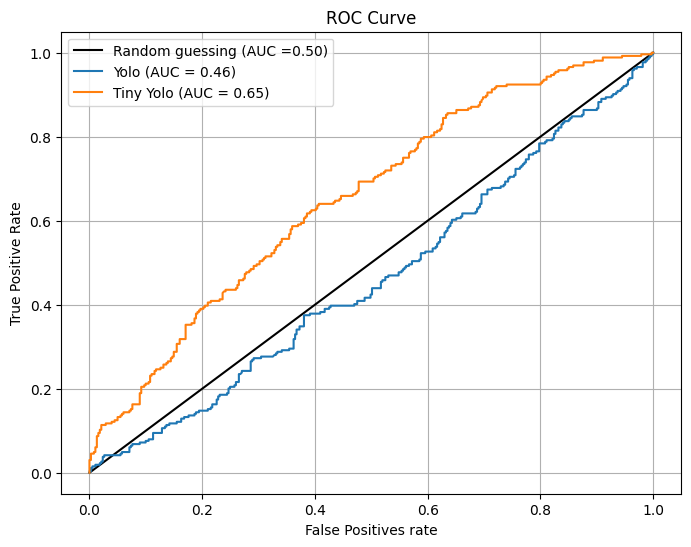

In [111]:
roc_tiny_df = pd.read_csv('performance/tiny_yolo_roc_curve.csv')
roc_df = pd.read_csv('performance/yolo_roc_curve.csv')

auc_tiny = roc_tiny_df["ROC_AUC"][0]
auc = roc_df["ROC_AUC"][0]


plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='black', label='Random guessing (AUC =0.50)')
plt.plot(roc_df['FalsePositiveRate'], roc_df['TruePositiveRate'], label=f"Yolo (AUC = {auc:.2f})")
plt.plot(roc_tiny_df['FalsePositiveRate'], roc_tiny_df['TruePositiveRate'], label=f"Tiny Yolo (AUC = {auc_tiny:.2f})")
plt.xlabel("False Positives rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve")
plt.legend()
plt.grid(True)

plt.savefig("graphs/roc.pdf", bbox_inches='tight')

plt.show()

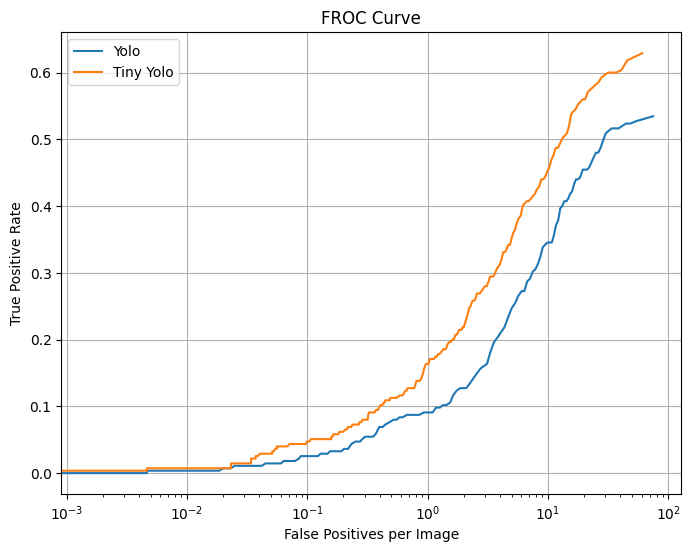

In [112]:
froc_tiny_df = pd.read_csv('performance/tiny_yolo_froc_curve.csv')
froc_df = pd.read_csv('performance/yolo_froc_curve.csv')


plt.figure(figsize=(8, 6))
plt.plot(froc_df['FalsePositivesPerImage'], froc_df['Sensitivity'], label=f"Yolo")
plt.plot(froc_tiny_df['FalsePositivesPerImage'], froc_tiny_df['Sensitivity'], label=f"Tiny Yolo")
plt.xlabel("False Positives per Image")
plt.ylabel("True Positive Rate")
plt.xscale('log')
plt.title(f"FROC Curve")
plt.legend()
plt.grid(True)

plt.savefig("graphs/froc.pdf", bbox_inches='tight')

plt.show()

## Prediction Examples

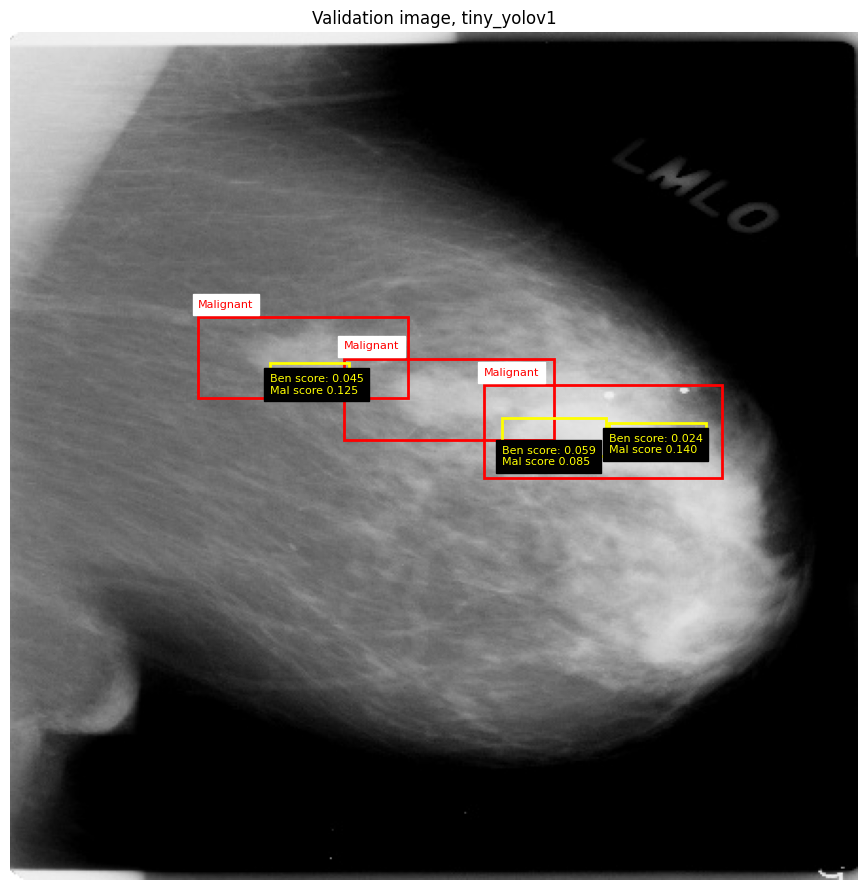

In [113]:
show_pred_example(model_tiny, "data/images/val/Mass-Training_P_00802_LEFT_MLO.jpg", "data/labels/val/Mass-Training_P_00802_LEFT_MLO.txt",
                         3, "Validation image, tiny_yolov1" )

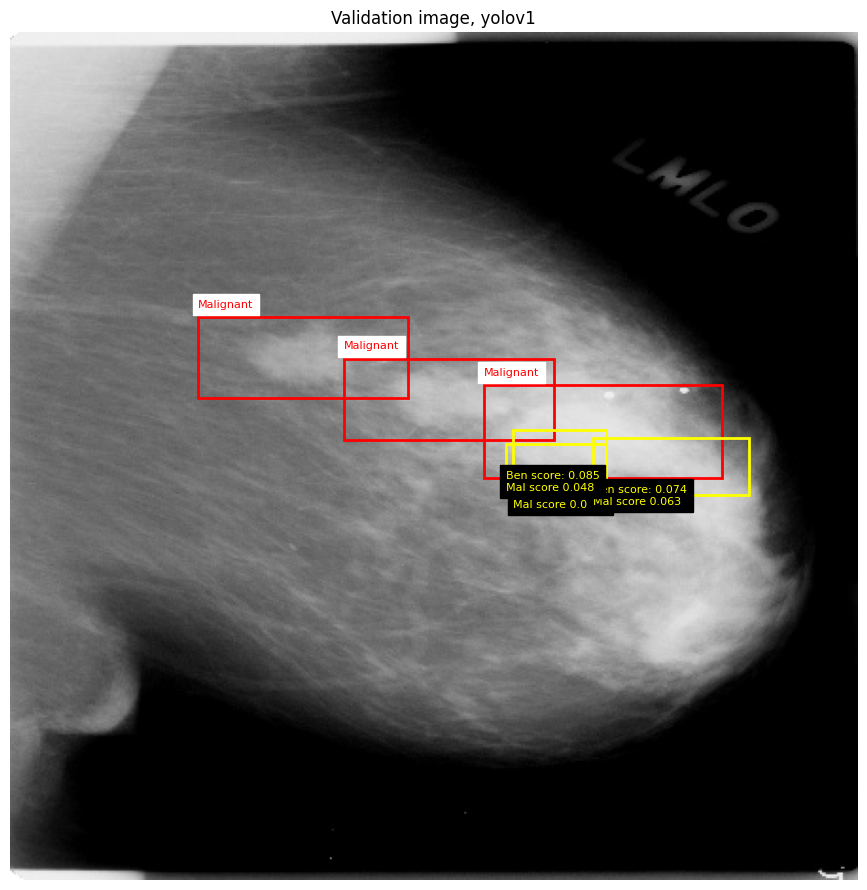

In [118]:
show_pred_example(model, "data/images/val/Mass-Training_P_00802_LEFT_MLO.jpg", "data/labels/val/Mass-Training_P_00802_LEFT_MLO.txt",
                         3, "Validation image, yolov1" )

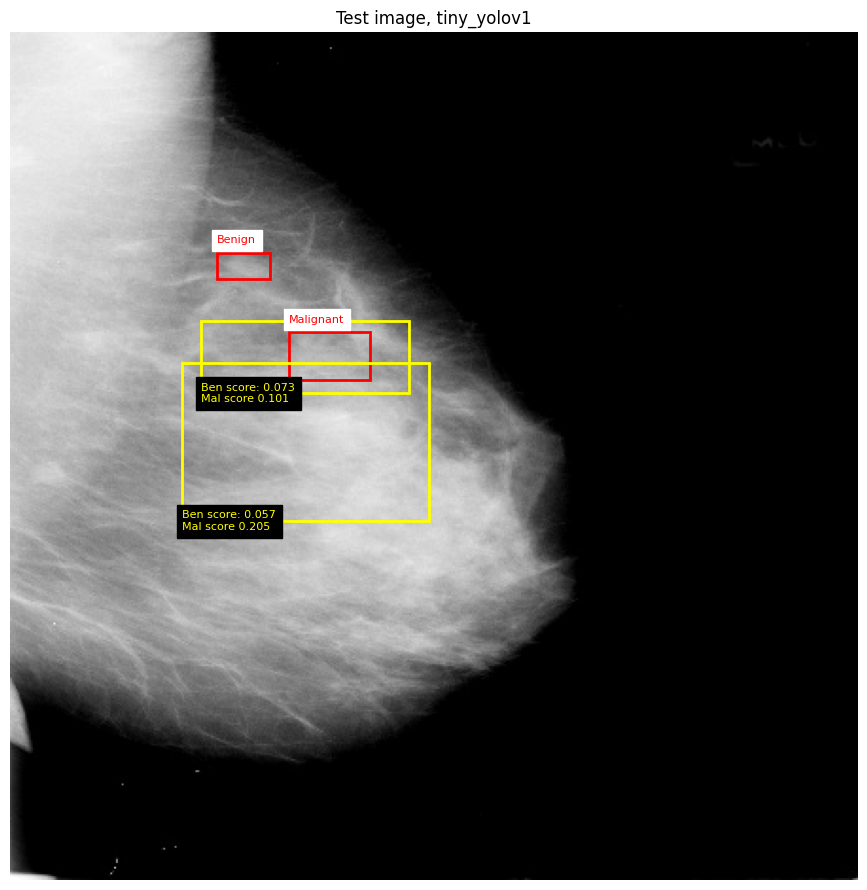

In [115]:
show_pred_example(model_tiny, "data/images/test/Mass-Test_P_00969_LEFT_MLO.jpg", "data/labels/test/Mass-Test_P_00969_LEFT_MLO.txt",
                         2, "Test image, tiny_yolov1" )

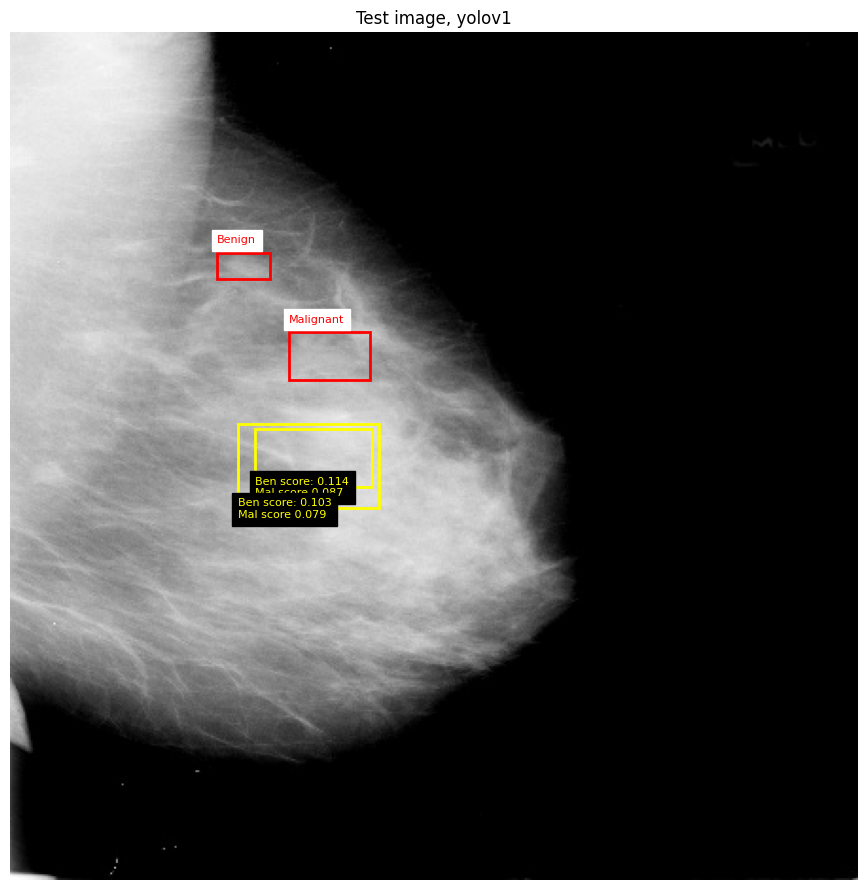

In [116]:
show_pred_example(model, "data/images/test/Mass-Test_P_00969_LEFT_MLO.jpg", "data/labels/test/Mass-Test_P_00969_LEFT_MLO.txt",
                         2, "Test image, yolov1" )